<a href="https://colab.research.google.com/github/saeed-art/BR_001/blob/main/demo_hqsam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

if os.path.exists('sam-hq'):
    !rm -rf sam-hq
!git clone https://github.com/SysCV/sam-hq.git
!pip install timm
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor

PyTorch version: 2.6.0+cu124
CUDA is available: True
Cloning into 'sam-hq'...
remote: Enumerating objects: 777, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 777 (delta 196), reused 141 (delta 141), pack-reused 489 (from 2)
Receiving objects: 100% (777/777), 70.92 MiB | 13.55 MiB/s, done.
Resolving deltas: 100% (261/261), done.


In [4]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint


--2025-07-07 20:57:57--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
Resolving huggingface.co (huggingface.co)... 3.165.102.6, 3.165.102.58, 3.165.102.128, ...
Connecting to huggingface.co (huggingface.co)|3.165.102.6|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/e1a6c385d62bf005ded91a54d5ec55c985cfc4103ef89c08d90f39f04934c343?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sam_hq_vit_l.pth%3B+filename%3D%22sam_hq_vit_l.pth%22%3B&Expires=1751925478&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTkyNTQ3OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kOS80ZS9kOTRlMDQ5OTJhYzRlM2VhNDVmY2MxYzUyMzk3NDU0MGNkYmVmMjc0ZTI5NWQ0YWFhY2M2OWI0ZjE5ZWU2M2I3L2UxYTZjMzg1ZDYyYmYwMDVkZWQ5MWE1NGQ1ZWM1NWM5ODVjZmM0MTAzZWY4OWMwOGQ5MGYzOWYwNDkzNGMzNDM%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj

In [5]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.axis('off')
        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [6]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

<All keys matched successfully>


Score: 0.894


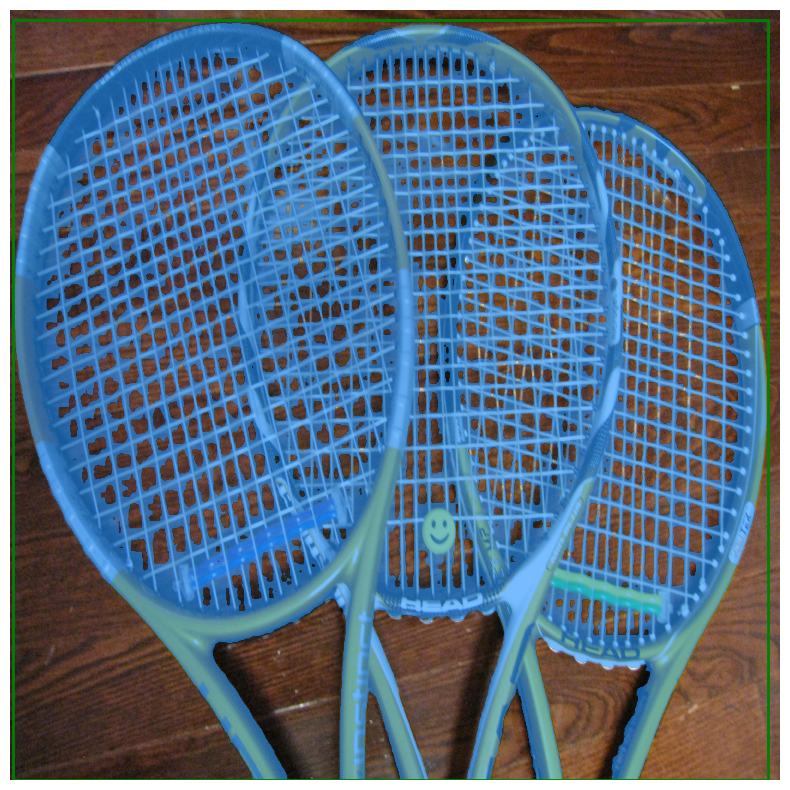

In [7]:
image = cv2.imread('demo/input_imgs/example0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[4,13,1007,1023]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

In [13]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content/sam-hq/sam-hq


In [14]:
# make data folder at home directory
!mkdir -p {HOME}/data

In [15]:
# Download example images

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data


Score: 0.452


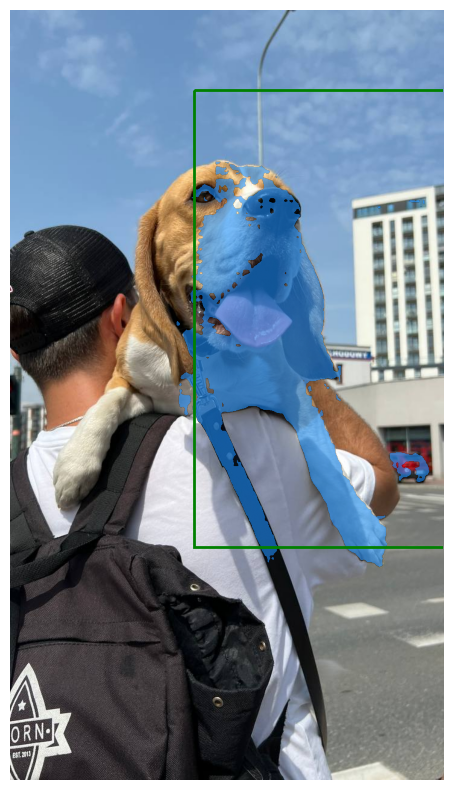

In [16]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[306, 132, 925, 893]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

In [17]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.4/837.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.0 MB/s eta 0:00:00


In [20]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [21]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [22]:
widget.bboxes

[{'x': 11, 'y': 215, 'width': 655, 'height': 736, 'label': ''}]

In [23]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

In [30]:
predictor.set_image(image)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)

Score: 0.954


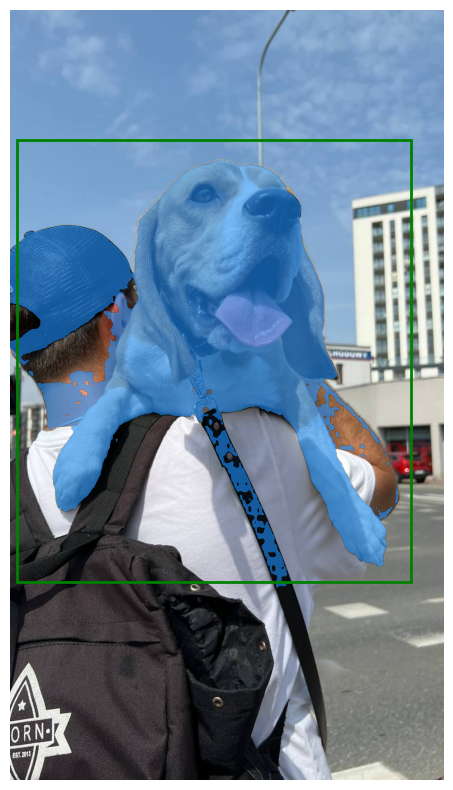

In [31]:
input_box = boxes
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.920


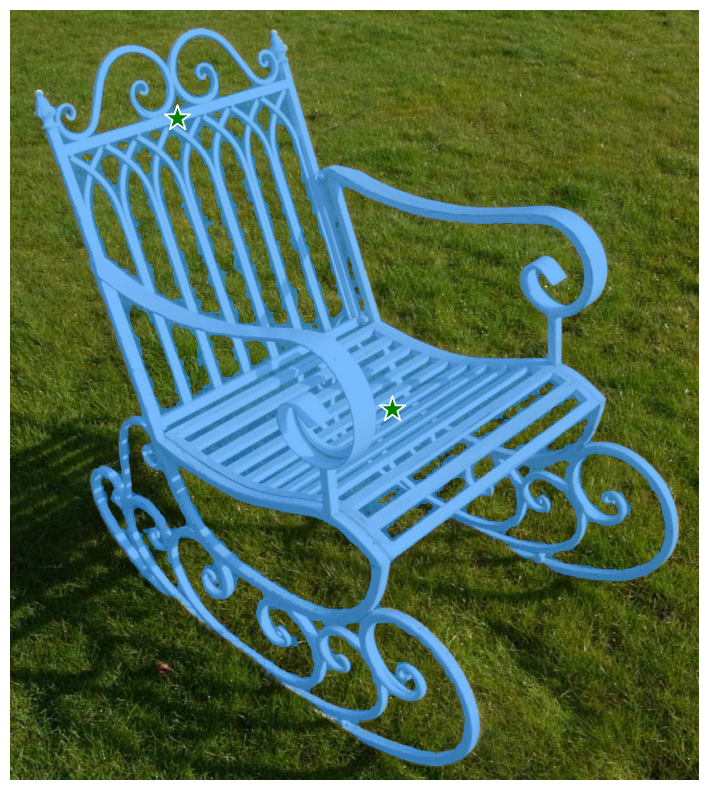

In [ ]:
image = cv2.imread('demo/input_imgs/example2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[495,518],[217,140]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.911


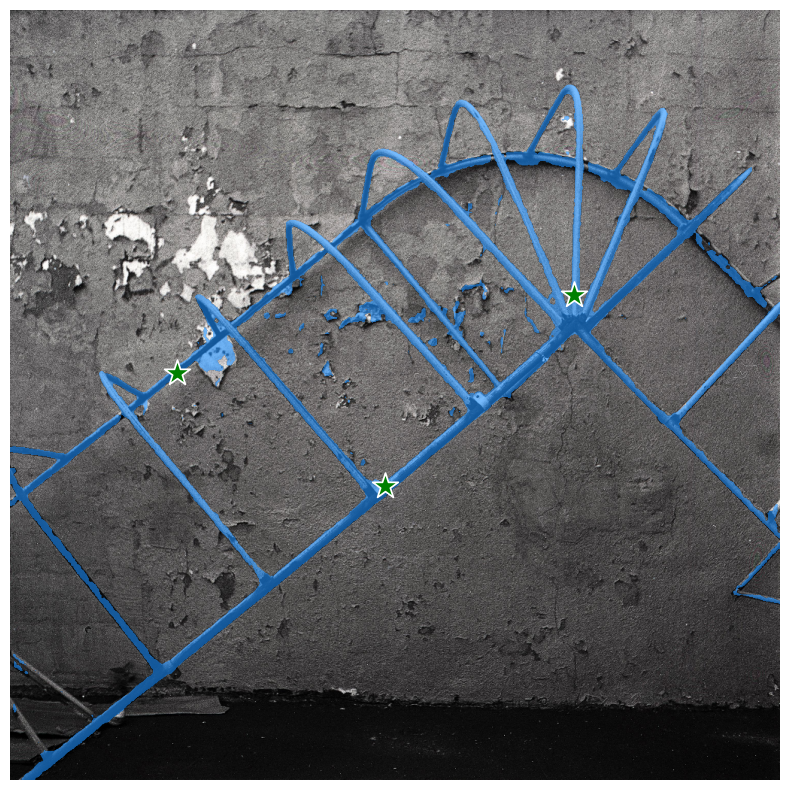

In [ ]:
image = cv2.imread('demo/input_imgs/example3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[221,482],[498,633],[750,379]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.973


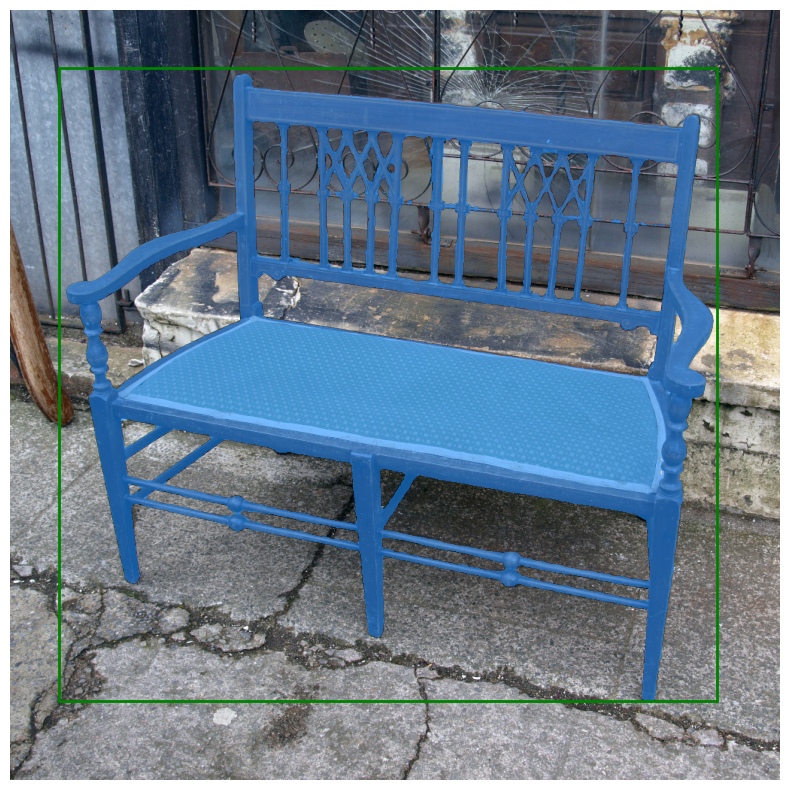

In [ ]:
image = cv2.imread('demo/input_imgs/example4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[64,76,940,919]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.967


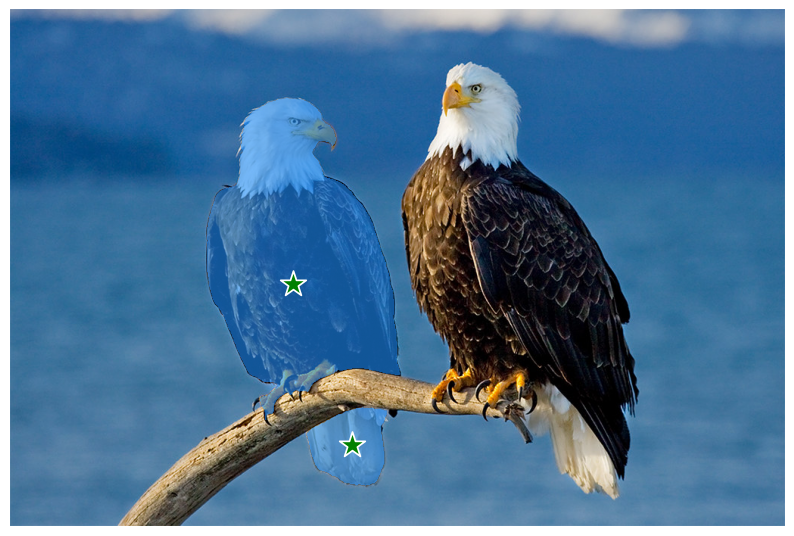

In [ ]:
image = cv2.imread('demo/input_imgs/example5.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[373,363], [452, 575]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.990


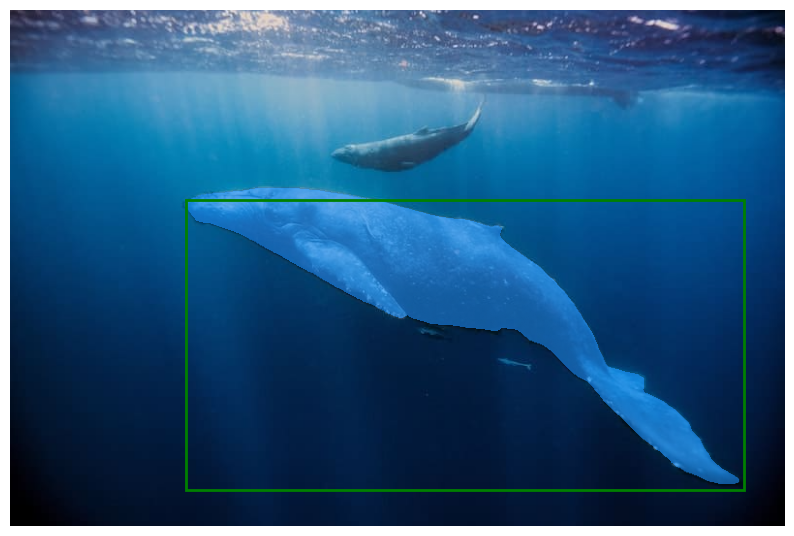

In [ ]:
image = cv2.imread('demo/input_imgs/example6.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[181, 196, 757, 495]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.715
Score: 0.968


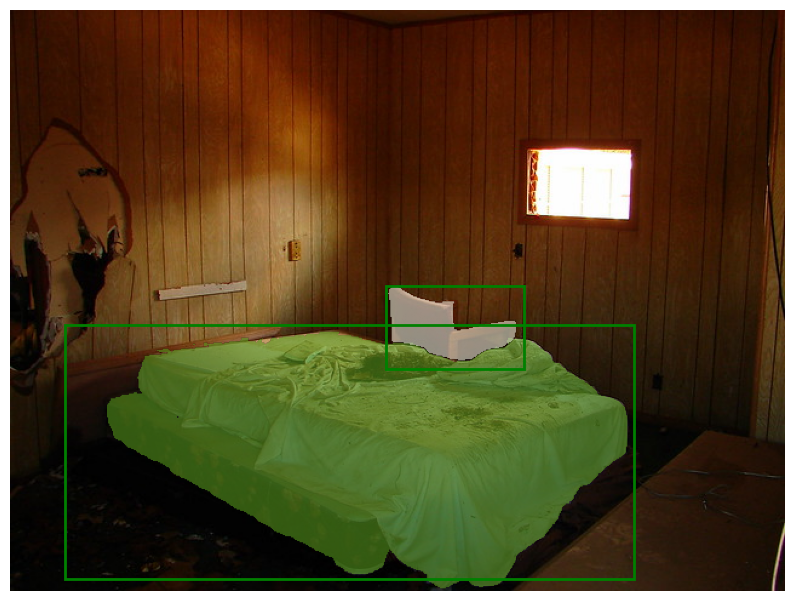

In [ ]:
image = cv2.imread('demo/input_imgs/example7.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# multi box input
input_box = torch.tensor([[45,260,515,470], [310,228,424,296]],device=predictor.device)
transformed_box = predictor.transform.apply_boxes_torch(input_box, image.shape[:2])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict_torch(
    point_coords=input_point,
    point_labels=input_label,
    boxes=transformed_box,
    multimask_output=False,
    hq_token_only=False,
)
masks = masks.squeeze(1).cpu().numpy()
scores = scores.squeeze(1).cpu().numpy()
input_box = input_box.cpu().numpy()
show_res_multi(masks, scores, input_point, input_label, input_box, image)

In [26]:
import supervision as sv